## **0. 사전 설치 리스트**


In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install graphviz
    # 한글 깨짐 방지
    !sudo apt-get install -y fonts-nanum 
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
import numpy as np
import seaborn as sns
import eli5

from pandas_profiling import ProfileReport
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OrdinalEncoder, PolynomialEncoder, TargetEncoder, OneHotEncoder, HelmertEncoder
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler

## **1. 취합 데이터 불러오기**

In [ ]:
# 경로 설정
PATH = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session2/Example_data/session2_project/'
CSV_LIST = ['sur_18_20.csv', 'sur_18_20_add.csv', 'add_data.csv']

# 불러오기
sur_18_20 = pd.read_csv(PATH + CSV_LIST[0], sep=',') # 최초로 가져온 설문조사 데이터
sur_18_20_add = pd.read_csv(PATH + CSV_LIST[1], sep=',') # 설문조사에 추가 자료 합친 데이터
add_data = pd.read_csv(PATH + CSV_LIST[2], sep=',') # 설문조사 이외에 추가로 취합한 데이터

# 형태 확인
sur_18_20.shape, sur_18_20_add.shape, add_data.shape

((72676, 48), (72676, 59), (462, 33))

## **2. Train/Validation/Test 및 Feature/Target 분리**

- 데이터 분리 기준은 무작위로 진행됨을 기본으로 하지만
  Target feature의 class 비율은 유지하면서 분리를 진행

- 또한 Train/Validation/Test 비율은 6:2:2로 설정

- 이에따라 위에서 분리된 각 데이터의 class는 86.5 : 13.5를 그대로 유지

In [ ]:
# target, feature 선언
target = '물의를일으켰는가'
features = sur_18_20.drop(columns = [target]).columns

# train+val, test 분리
train_val, test = train_test_split(sur_18_20, train_size = 0.80, test_size = 0.20, stratify = sur_18_20[target], random_state = 2)

# train, val 분리
train, val = train_test_split(train_val, train_size = 0.75, test_size = 0.25, stratify = train_val[target], random_state = 2)

# train, test 지정 (feature, target 별)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# 지정 결과 확인 - 굳
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((43605, 47), (43605,), (14535, 47), (14535,), (14536, 47), (14536,))

## **3. 모델 학습 진행 및 결과 리포팅**

- 의사결정나무 모델을 베이스로 하여 학습 진행
- 훈련 정확도 및 검증 정확도가 모두 높지만 다수 범주 비율을 고려하면 모델이 제대로 분류를 하지 못하고 있음
- 실제로 테스트 데이터로 진행한 classification_report에서 1 class에 대한 recall이 굉장히 낮음
- randomforest, XGboost로 모델을 바꾸기 전에, Date quality에 대한 보충이 필요할 것으로 판단 됨

In [ ]:
#변수 선언

#순서 없고 범주형인 Feature (이진형 포함) - TargetEncoder
col_rename_tar = ['시도', '시군구', '성별', '연령대', '기타운전중한행동', '자주이용하는교통수단', '실행연도']

#순서 있고 범주형인 Feature - OrdinalEncoder
col_rename_ord = ['정지선위반여부', '차로변경점등위반여부', '신호위반여부', '안전띠미착용여부(운전석,일반도로)', '안전띠미착용여부(조수석,일반도로)', '안전띠미착용여부(뒷자석,일반도로)',
              '안전띠미착용여부(운전석,고속도로)', '안전띠미착용여부(조수석,고속도로)', '안전띠미착용여부(뒷자석,고속도로)', '음주여부', '음주운전여부',
              '규정속도위반여부', '운전중스마트폰사용여부(일반도로)', '운전중스마트폰사용여부(고속도로)', '회전교차로이용여부', '회전교차로우선진입여부', '횡단보도이용간신호위반여부',
              '횡단보도이용간스마트폰사용여부', '무단횡단여부']

#순서 있고 범주형인 Feature이고 동일한 간격으로 배치 된 것 - Polynomial Coding
col_rename_pol = ['교통안전중요성', '교통안전중요성(지인)', '정지선중요도', '점등중요도', '신호중요도', '안전띠중요도(일반도로)', '안전띠중요도(고속도로)',
              '음주운전인식', '혈중알콜농도강화법안지지도', '규정속도위반인식', '운전속도인식(타인대비)', '허용가능한과속수준(고속도로)',
              '허용가능한과속수준(생활도로)', '제한속도하향법안지지도', '운전중스마트폰사용여부인식', '스마트폰활용금지법안지지도',
              '회전교차로우선순위인식', '횡단보도이용간신호위반인식', '횡단보도이용간스마트폰사용인식', '무단횡단인식']

In [ ]:
# 파이프라인 설정
pipe = make_pipeline(
            TargetEncoder(cols = col_rename_tar),
            OrdinalEncoder(cols = col_rename_ord, handle_missing = 'value'),
            PolynomialEncoder(cols = col_rename_pol),
            SimpleImputer(),
            DecisionTreeClassifier(max_depth = 5, random_state = 2)
            ).fit(X_train, y_train)

print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

훈련 정확도 0.8651989450751061
검증 정확도 0.8652218782249742


In [ ]:
# 각 평가지표 확인
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     12560
           1       0.75      0.01      0.02      1975

    accuracy                           0.87     14535
   macro avg       0.81      0.51      0.48     14535
weighted avg       0.85      0.87      0.80     14535



## **4. 정보 누수 확인**

- 별도의 정보 누수는 없는 것으로 '예측'되나, Raw Data를 먼저 보충한 후 다시 확인해 볼 예정

   (확보한 데이터 자체가 타겟과 연관성이 낮은 것으로 파악되기 때문에)

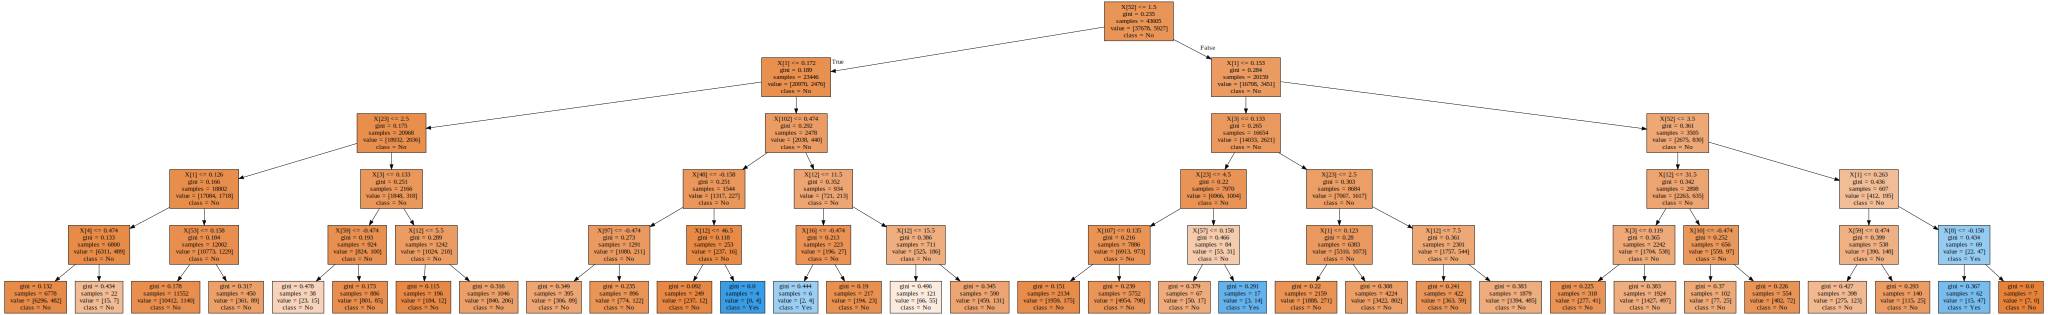

In [ ]:
tree = pipe.named_steps['decisiontreeclassifier']

feature_names = sur_18_20.drop(columns=[target]).columns.tolist()
target_name = np.array(['No', 'Yes'])

from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함. 
export_graphviz(tree, out_file="tree.dot", class_names=target_name,
               impurity=True, filled=True)

import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## **5. 데이터 변형 및 맵핑 진행 (+ 데이터 추가)**

- Heatmap을 통해 target과의 관련성이 떨어지는 column drop
- 낱개로 나누어져 있는 데이터의 합계 및 평균 column 추가

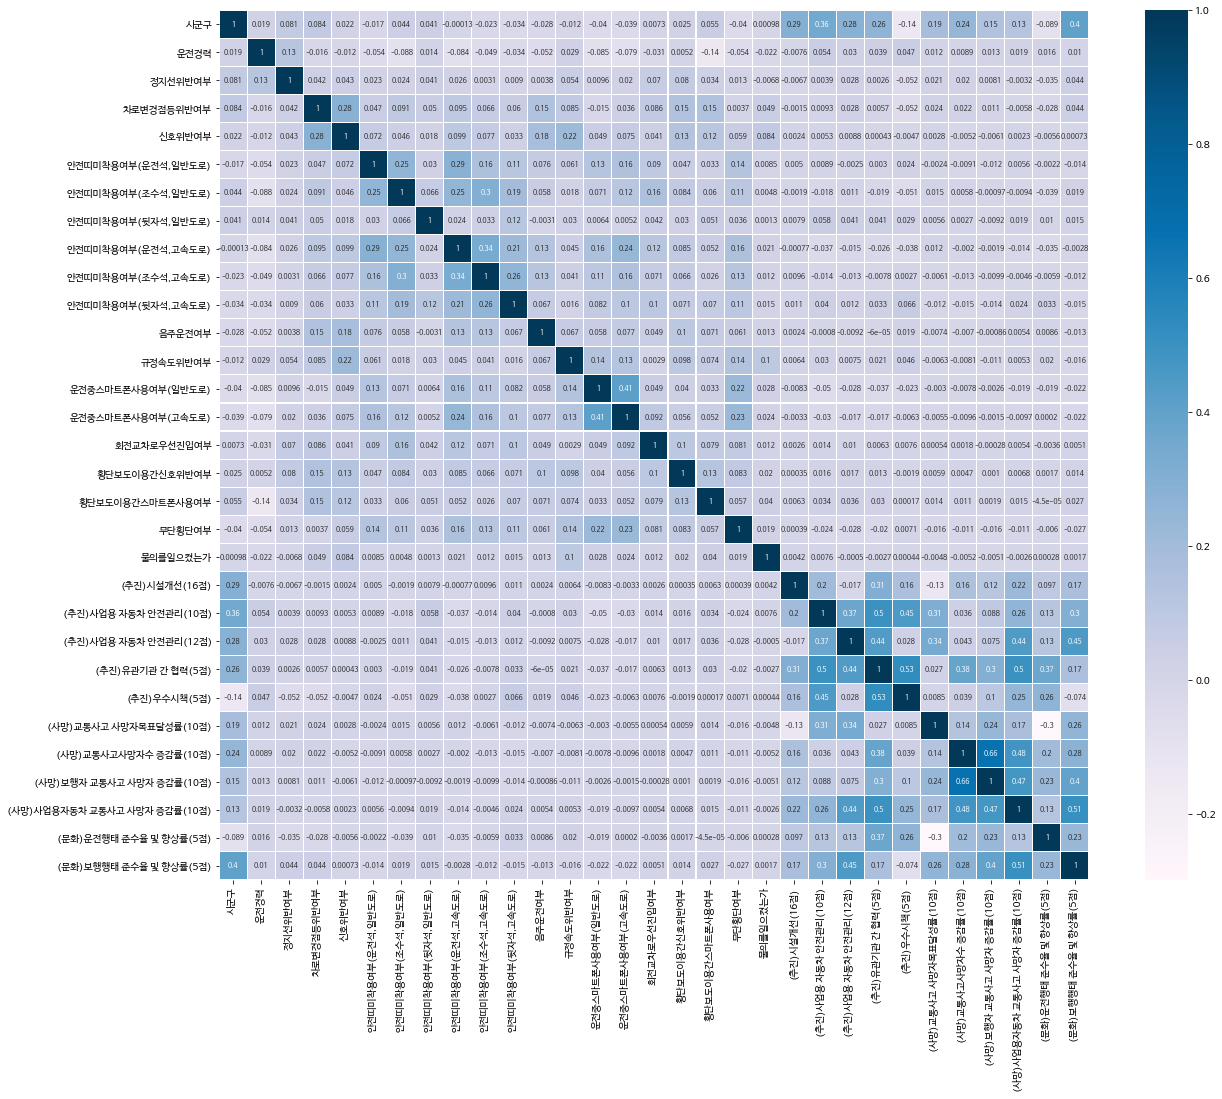

In [ ]:
# 변수간 상관계수 확인 - heatmap
colormap = plt.cm.PuBu

plt.rc('font', family='NanumBarunGothic') 
plt.rc('axes', unicode_minus=False)

plt.figure(figsize=(20, 16))
sns.heatmap(sur_18_20_add.corr(), linewidths = 0.1, vmax = 1.0, square = True,
            cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 7});

In [ ]:
# 기존 설문조사 데이터 변형

# 안전띠 미착용 여부 관련 데이터는 횟수로 답변을 받고 있음 -> 하나의 column으로 횟수를 모두 합치기 (범주형 -> 연속형으로 변환)
sur_18_20_add['30일간안전띠미착용횟수'] = sur_18_20_add['안전띠미착용여부(운전석,일반도로)'] + sur_18_20_add['안전띠미착용여부(조수석,일반도로)'] + sur_18_20_add['안전띠미착용여부(뒷자석,일반도로)'] + sur_18_20_add['안전띠미착용여부(운전석,고속도로)'] + sur_18_20_add['안전띠미착용여부(조수석,고속도로)'] + sur_18_20_add['안전띠미착용여부(뒷자석,고속도로)']

# 운전 중 스마트폰 사용 여부(일반도로) 및 운전 중 스마트폰 사용 여부(고속도로)의 횟수 답변을 하나의 column으로 모두 합치기
sur_18_20_add['운전중스마트폰사용여부'] = (sur_18_20_add['운전중스마트폰사용여부(일반도로)'] + sur_18_20_add['운전중스마트폰사용여부(고속도로)']) / 2

# 허용 가능한 과속 수준(고속도로) 및 허용 가능한 과속 수준(생활도로) 결과 값의 평균 값을 의미하는 column을 새로 생성 
rep_li = ['허용가능한과속수준(고속도로)', '허용가능한과속수준(생활도로)']

sur_18_20_add[rep_li] = sur_18_20_add[rep_li].replace({'속도 준수': 0,
                                                        '5km/h 초과': 5,
                                                        '10km/h 초과': 10,
                                                        '15km/h 초과': 15,
                                                        '20km/h 초과': 20})

sur_18_20_add['허용가능한과속수준'] = (sur_18_20_add['허용가능한과속수준(고속도로)'] + sur_18_20_add['허용가능한과속수준(생활도로)']) / 2

# 안전띠 미착용 원본 데이터는 삭제 : 상관계수 자체도 낮아서 유지할 필요가 없다고 판단
seat_belt_drop = ['안전띠미착용여부(운전석,일반도로)', '안전띠미착용여부(조수석,일반도로)', '안전띠미착용여부(뒷자석,일반도로)', '안전띠미착용여부(운전석,고속도로)', '안전띠미착용여부(조수석,고속도로)', '안전띠미착용여부(뒷자석,고속도로)']

# 회전교차로 관련 데이터는 다른 지표 산정시 대체로 참고자료로만 활용하고 있으며, 상관계수도 낮기 떄문에 유지할 필요가 없다고 판단하여 삭제
rotate_drop = ['회전교차로이용여부', '회전교차로우선진입여부', '회전교차로우선순위인식']

# 횡단보도 관련 데이터는 운전자의 법규 위반에 해당되지 않는 항목이라고 판단되어 삭제
cross_drop = ['횡단보도이용간신호위반여부', '횡단보도이용간신호위반인식', '횡단보도이용간스마트폰사용여부', '횡단보도이용간스마트폰사용인식', '무단횡단여부', '무단횡단인식']

# 지인, 타인 관련 데이터 삭제 (+ 상관계수도 낮아 현 시점을 기준으로 무의미하다고 판단)
ano_drop = ['교통안전중요성(지인)', '운전속도인식(타인대비)']

final_list = seat_belt_drop + rotate_drop + cross_drop + ano_drop

# 삭제
sur_18_20_add = sur_18_20_add.drop(columns = final_list, axis = 1)

# 결과 확인
sur_18_20_add.head(1)

,시군구,성별,연령대,교통안전중요성,운전경력,정지선위반여부,정지선중요도,차로변경점등위반여부,점등중요도,신호위반여부,신호중요도,안전띠중요도(일반도로),안전띠중요도(고속도로),음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),기타운전중한행동,운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,자주이용하는교통수단,실행연도,시도,물의를일으켰는가,(추진)시설개선(16점),(추진)사업용 자동차 안전관리(10점),(추진)사업용 자동차 안전관리(12점),(추진)유관기관 간 협력(5점),(추진)우수시책(5점),(사망)교통사고 사망자목표달성률(10점),(사망)교통사고사망자수 증감률(10점),(사망)보행자 교통사고 사망자 증감률(10점),(사망)사업용자동차 교통사고 사망자 증감률(10점),(문화)운전행태 준수율 및 향상률(5점),(문화)보행행태 준수율 및 향상률(5점),30일간안전띠미착용횟수,운전중스마트폰사용여부,허용가능한과속수준
0,1,남성,20대,긍정,1,2.5,매우 그렇다,1.0,매우 그렇다,0.0,매우 그렇다,매우 그렇다,그렇다,술을 전혀 마시지 않는다,0.0,보통이다,긍정,2.5,그렇다,15,5,지지,1.0,0.0,문자 및 SNS 사용,그렇다,반대,승용차 자차 운전,2018년,서울특별시,0,10.2,10.4,9.3,4.4,4.6,9.2,8,8,8,5.0,2.8,4.5,0.5,10.0


In [ ]:
# 새로 취합한 데이터 변형
# (추진), (사망), (문화) 별 총점 및 전체 총점 column 생성
sur_18_20_add['추진 합계(48점)'] = sur_18_20_add['(추진)시설개선(16점)'] + sur_18_20_add['(추진)사업용 자동차 안전관리(10점)'] + sur_18_20_add['(추진)사업용 자동차 안전관리(12점)']  + sur_18_20_add['(추진)유관기관 간 협력(5점)']  + sur_18_20_add['(추진)우수시책(5점)']
sur_18_20_add['사망 합계(40점)'] = sur_18_20_add['(사망)교통사고 사망자목표달성률(10점)'] + sur_18_20_add['(사망)교통사고사망자수 증감률(10점)'] + sur_18_20_add['(사망)보행자 교통사고 사망자 증감률(10점)']  + sur_18_20_add['(사망)사업용자동차 교통사고 사망자 증감률(10점)']
sur_18_20_add['문화 합계(10점)'] = sur_18_20_add['(문화)운전행태 준수율 및 향상률(5점)'] + sur_18_20_add['(문화)보행행태 준수율 및 향상률(5점)']
sur_18_20_add['총계(98점)'] = sur_18_20_add['추진 합계(48점)'] + sur_18_20_add['사망 합계(40점)'] + sur_18_20_add['문화 합계(10점)']

# 결과 확인
sur_18_20_add.head(1)

,시군구,성별,연령대,교통안전중요성,운전경력,정지선위반여부,정지선중요도,차로변경점등위반여부,점등중요도,신호위반여부,신호중요도,안전띠중요도(일반도로),안전띠중요도(고속도로),음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),기타운전중한행동,운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,자주이용하는교통수단,실행연도,시도,물의를일으켰는가,(추진)시설개선(16점),(추진)사업용 자동차 안전관리(10점),(추진)사업용 자동차 안전관리(12점),(추진)유관기관 간 협력(5점),(추진)우수시책(5점),(사망)교통사고 사망자목표달성률(10점),(사망)교통사고사망자수 증감률(10점),(사망)보행자 교통사고 사망자 증감률(10점),(사망)사업용자동차 교통사고 사망자 증감률(10점),(문화)운전행태 준수율 및 향상률(5점),(문화)보행행태 준수율 및 향상률(5점),30일간안전띠미착용횟수,운전중스마트폰사용여부,허용가능한과속수준,추진 합계(48점),사망 합계(40점),문화 합계(10점),총계(98점)
0,1,남성,20대,긍정,1,2.5,매우 그렇다,1.0,매우 그렇다,0.0,매우 그렇다,매우 그렇다,그렇다,술을 전혀 마시지 않는다,0.0,보통이다,긍정,2.5,그렇다,15,5,지지,1.0,0.0,문자 및 SNS 사용,그렇다,반대,승용차 자차 운전,2018년,서울특별시,0,10.2,10.4,9.3,4.4,4.6,9.2,8,8,8,5.0,2.8,4.5,0.5,10.0,38.9,33.2,7.8,79.9


In [ ]:
# 전체 응답 항목 중 중복이 발생한 데이터 삭제
sur_18_20_add = sur_18_20_add.drop_duplicates(keep = 'first')

# 최종 확인
sur_18_20_add.head(1)

,시군구,성별,연령대,교통안전중요성,운전경력,정지선위반여부,정지선중요도,차로변경점등위반여부,점등중요도,신호위반여부,신호중요도,안전띠중요도(일반도로),안전띠중요도(고속도로),음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),기타운전중한행동,운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,자주이용하는교통수단,실행연도,시도,물의를일으켰는가,(추진)시설개선(16점),(추진)사업용 자동차 안전관리(10점),(추진)사업용 자동차 안전관리(12점),(추진)유관기관 간 협력(5점),(추진)우수시책(5점),(사망)교통사고 사망자목표달성률(10점),(사망)교통사고사망자수 증감률(10점),(사망)보행자 교통사고 사망자 증감률(10점),(사망)사업용자동차 교통사고 사망자 증감률(10점),(문화)운전행태 준수율 및 향상률(5점),(문화)보행행태 준수율 및 향상률(5점),30일간안전띠미착용횟수,운전중스마트폰사용여부,허용가능한과속수준,추진 합계(48점),사망 합계(40점),문화 합계(10점),총계(98점)
0,1,남성,20대,긍정,1,2.5,매우 그렇다,1.0,매우 그렇다,0.0,매우 그렇다,매우 그렇다,그렇다,술을 전혀 마시지 않는다,0.0,보통이다,긍정,2.5,그렇다,15,5,지지,1.0,0.0,문자 및 SNS 사용,그렇다,반대,승용차 자차 운전,2018년,서울특별시,0,10.2,10.4,9.3,4.4,4.6,9.2,8,8,8,5.0,2.8,4.5,0.5,10.0,38.9,33.2,7.8,79.9


## **6. Train/Validation/Test 및 Feature/Target 분리**

**해당 절차의 코드는 분리하는 원본 데이터를 제외하고 위의 2번과 동일**

In [ ]:
# feature 선언
features = sur_18_20_add.drop(columns = [target]).columns

# train+val, test 분리
train_val, test = train_test_split(sur_18_20_add, train_size = 0.80, test_size = 0.20, stratify = sur_18_20_add[target], random_state = 2)

# train, val 분리
train, val = train_test_split(train_val, train_size = 0.75, test_size = 0.25, stratify = train_val[target], random_state = 2)

# train, test 지정 (feature, target 별)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# 지정 결과 확인 - 굳
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((43593, 48), (43593,), (14531, 48), (14531,), (14532, 48), (14532,))

## **7. 모델 재학습 결과 리포팅**

- 의사결정나무, 랜덤포레스트 모델을 베이스로 하여 학습을 진행

  (Target의 불균형 분포를 보정하기 위해 class_weight 파라미터 추가)

- 재학습 결과 과적합 현상이 의심되어 특성 중요도를 기반으로 불필요한 column을 지속적으로 삭제 진행

  (column drop의 기준은 의사결정나무 및 랜덤포레스트 두 모델에서 유의미한 중요도를 나타내지 않는 column)

- 랜덤포레스트 모델로 정보 누수가 의심되는 결과를 확인. 2차 데이터 추가 및 Drop 후에도 정보 누수의 현상이 보이는지 확인 필요

In [ ]:
# 가중치 설정
weight = len(y_train)/(2*np.bincount(y_train))

# 파이프라인 설정 - 의사결정나무
pipe = make_pipeline(
            OneHotEncoder(use_cat_names = True), # 특성 중요도를 빠르게 확인하기 위해 OneHotEncoder으로 간단히 진행
            SimpleImputer(),
            DecisionTreeClassifier(max_depth = 25,
                                   class_weight={0 : weight[0], 1 : weight[1]}, # 가중치 부여
                                   random_state = 2)
            ).fit(X_train, y_train)

print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

훈련 정확도 0.9643061959488909
검증 정확도 0.7830844401624114


In [ ]:
# 각 평가지표 확인 - 의사결정나무
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

# 과적합일 확률 높음
# Target = 1 값이 recall 및 f1-score가 모두 크게 상승 -> class_weight가 영향이 있었던 것으로 판단됨

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     12557
           1       0.26      0.33      0.30      1974

    accuracy                           0.78     14531
   macro avg       0.58      0.59      0.58     14531
weighted avg       0.81      0.78      0.79     14531



AUC score:  0.5971315683966423


Text(0, 0.5, 'TPR')

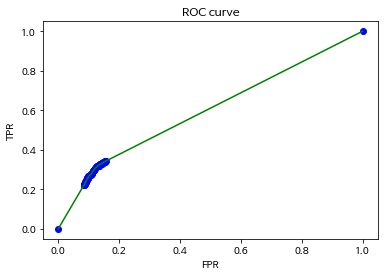

In [ ]:
# AUC, ROC 확인 - 의사결정나무
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

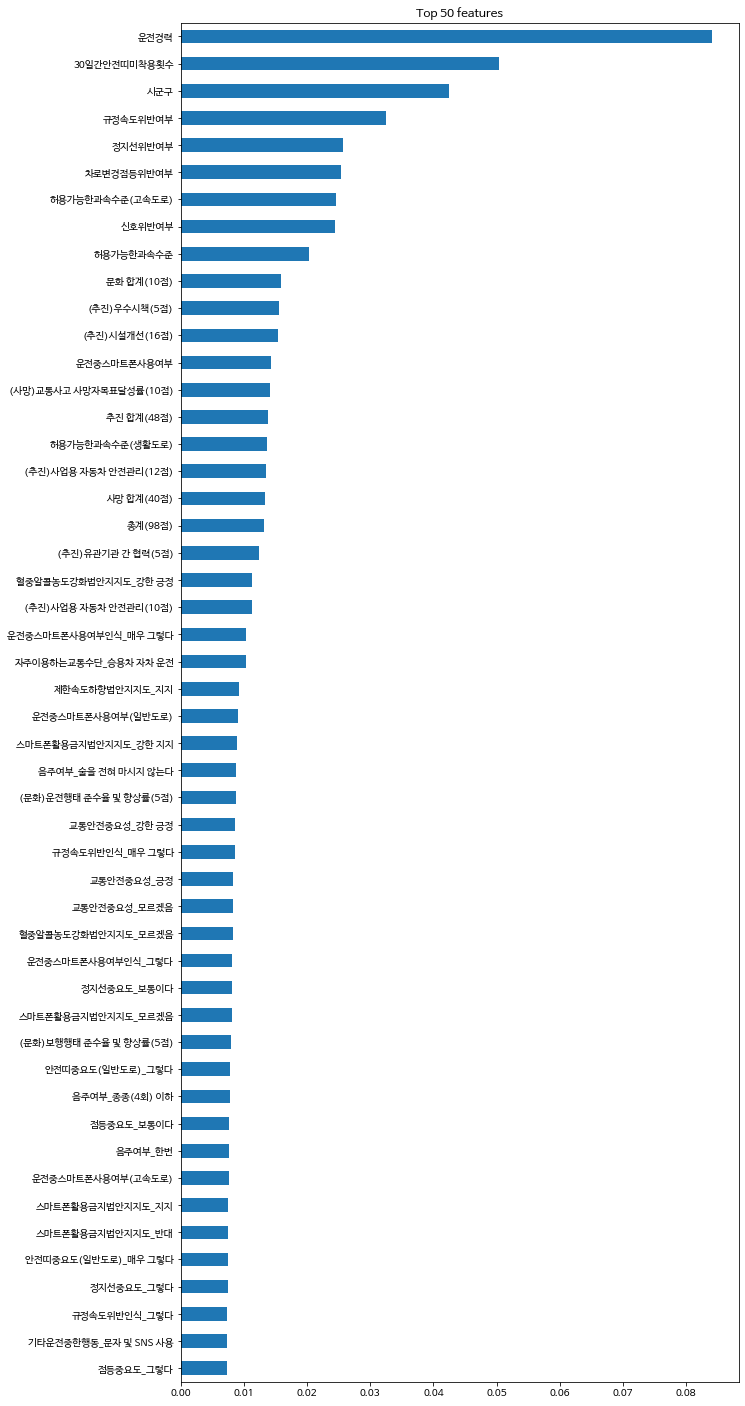

In [ ]:
# 특성 중요도 확인 - 의사결정나무
model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns

plt.rc('font', family='NanumBarunGothic') 
plt.rc('axes', unicode_minus=False)

importances = pd.Series(model_dt.feature_importances_, encoded_columns)

n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [ ]:
# 파이프라인 설정 - 랜덤포레스트
pipe_ran = make_pipeline(
    OneHotEncoder(use_cat_names = True),# 특성 중요도를 빠르게 확인하기 위해 OneHotEncoder으로 간단히 진행
    SimpleImputer(),
    RandomForestClassifier(class_weight = {0 : weight[0], 1 : weight[1]}, # 가중치 부여
                           random_state = 2, n_jobs = -1, oob_score = True)
)

pipe_ran.fit(X_train, y_train)
print('훈련 정확도', pipe_ran.score(X_train, y_train))
print('검증 정확도 ', pipe_ran.score(X_val, y_val))

훈련 정확도 1.0
검증 정확도  0.8691074255040947


In [ ]:
# 각 평가지표 확인 - 랜덤포레스트
y_pred = pipe_ran.predict(X_val)
print(classification_report(y_val, y_pred))

# 과적합일 확률 높음
# 의사결정나무보다 정확도 f1-score는 높지만, Target = 1의 f1-score는 크게 떨어짐
# Target = 0의 지표를 기반으로 모델이 Target = 0으로 모든 데이터를 분류하고 있다고 판단 됨

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     12557
           1       1.00      0.04      0.07      1974

    accuracy                           0.87     14531
   macro avg       0.93      0.52      0.50     14531
weighted avg       0.89      0.87      0.81     14531



AUC score:  0.7478628961560412


Text(0, 0.5, 'TPR')

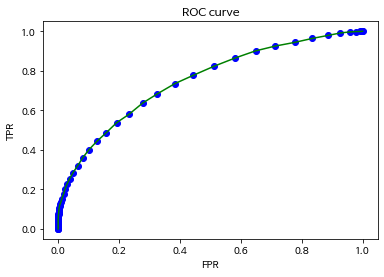

In [ ]:
# AUC, ROC 확인 - 랜덤포레스트
y_pred_proba = pipe_ran.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

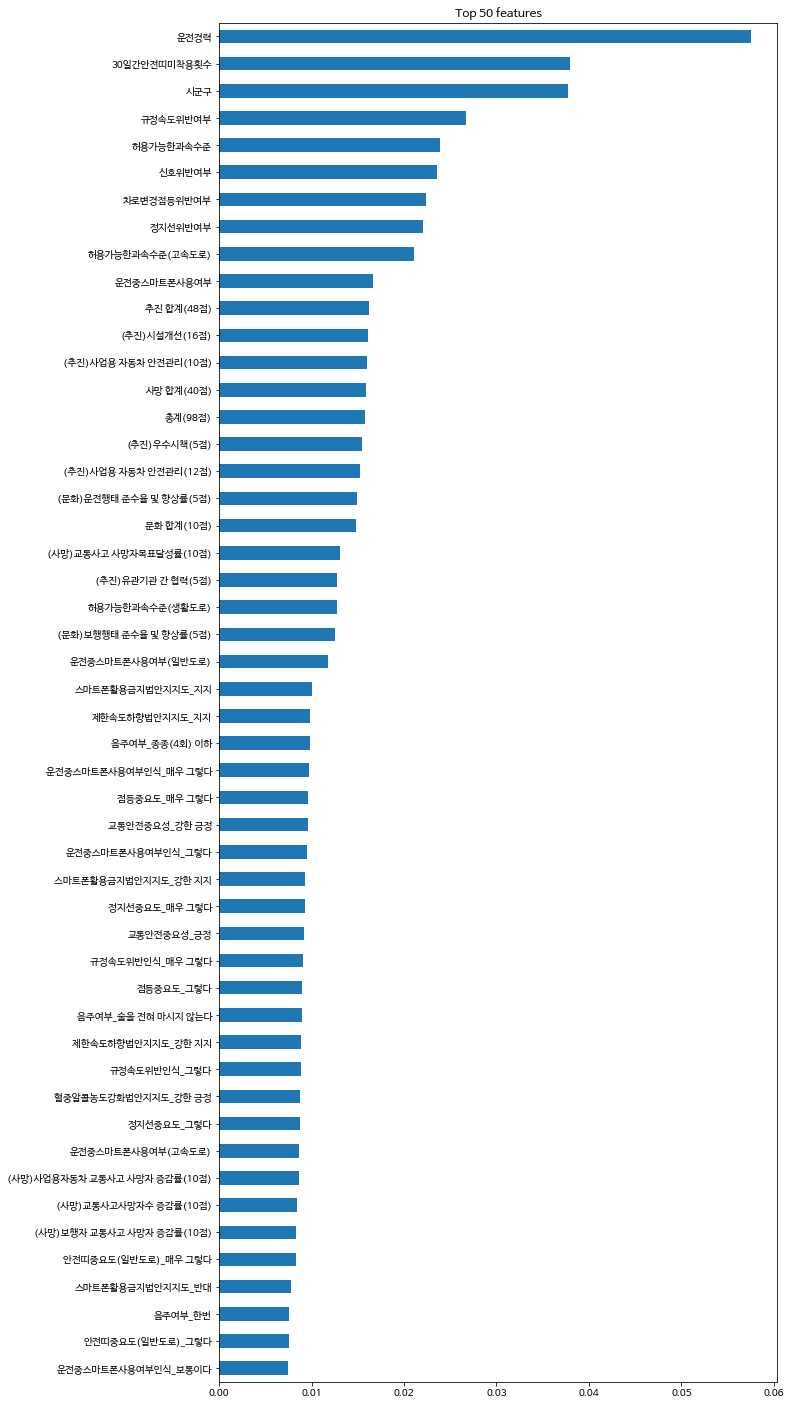

In [ ]:
# 특성 중요도 확인 - 랜덤포레스트
model_dt = pipe_ran.named_steps['randomforestclassifier']
enc = pipe_ran.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns

plt.rc('font', family='NanumBarunGothic') 
plt.rc('axes', unicode_minus=False)

importances = pd.Series(model_dt.feature_importances_, encoded_columns)

n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [ ]:
# 두 모델의 특성 중요도 결과를 기반으로 불필요한 column 삭제

# 1차 비교 후 삭제 리스트 취합
drop_list_add = ['점등중요도', '자주이용하는교통수단', '기타운전중한행동', '안전띠중요도(일반도로)', '안전띠중요도(고속도로)']

# 2차 비교 후 삭제 리스트 취합
drop_list_add2 = ['시도', '실행연도']

# 3차 비교 후 삭제 리스트 취합
drop_list_add3 = ['신호중요도', '정지선중요도', '(사망)교통사고 사망자목표달성률(10점)', '(사망)교통사고사망자수 증감률(10점)', '(사망)보행자 교통사고 사망자 증감률(10점)',
                 '(사망)사업용자동차 교통사고 사망자 증감률(10점)', '사망 합계(40점)']

final_list = drop_list_add + drop_list_add2 + drop_list_add3

# 2차 데이터 취합 때 drop_list_add2 column을 기준 ID로 활용해야 하기 때문에 기존 데이터를 Copy하여 Drop 진행
sur_18_20_add2 = sur_18_20_add.drop(columns = final_list, axis=1)
sur_18_20_add2.head(2)

,시군구,성별,연령대,교통안전중요성,운전경력,정지선위반여부,차로변경점등위반여부,신호위반여부,음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,물의를일으켰는가,(추진)시설개선(16점),(추진)사업용 자동차 안전관리(10점),(추진)사업용 자동차 안전관리(12점),(추진)유관기관 간 협력(5점),(추진)우수시책(5점),(문화)운전행태 준수율 및 향상률(5점),(문화)보행행태 준수율 및 향상률(5점),30일간안전띠미착용횟수,운전중스마트폰사용여부,허용가능한과속수준,추진 합계(48점),문화 합계(10점),총계(98점)
0,1,남성,20대,긍정,1,2.5,1.0,0.0,술을 전혀 마시지 않는다,0.0,보통이다,긍정,2.5,그렇다,15,5,지지,1.0,0.0,그렇다,반대,0,10.2,10.4,9.3,4.4,4.6,5.0,2.8,4.5,0.5,10.0,38.9,7.8,79.9
1,1,남성,20대,긍정,2,1.0,1.0,0.0,술을 전혀 마시지 않는다,4.5,보통이다,긍정,2.5,보통이다,10,0,모르겠음,1.0,1.0,그렇다,반대,1,10.2,10.4,9.3,4.4,4.6,5.0,2.8,10.0,1.0,5.0,38.9,7.8,79.9


## **8. 데이터 2차 추가 및 변형 진행**

In [ ]:
# 추가로 취합 할 데이터 변형

# 운전행태영역(55점), 교통안전영역(25점), 보행형태영역(20점) 합계 column을 새로 생성
add_data['영역합계(95점)'] = add_data['운전행태영역(55점)'] + add_data['교통안전영역(25점)'] + add_data['보행형태영역(20점)']

# 경상/부상 발생 수 및 사상 수 합계 column을 새로 생성
add_data['경상/부상발생합계(건)'] = add_data['경상발생건수(건)'] + add_data['부상발생건수(건)']
add_data['경상/부상사상합계(건)'] = add_data['경상사상자수(명)'] + add_data['부상사상자수(명)']

# 승용_, 승합_, 화물_, 특수_, 이륜_ 관련 데이터 총합 column을 새로 생성
add_data['승용_합계'] = add_data['승용_관용'] + add_data['승용_자가용'] + add_data['승용_영업용']
add_data['승합_합계'] = add_data['승합_관용'] + add_data['승합_자가용'] + add_data['승합_영업용']
add_data['화물_합계'] = add_data['화물_관용'] + add_data['화물_자가용'] + add_data['화물_영업용']
add_data['특수_합계'] = add_data['특수_관용'] + add_data['특수_자가용'] + add_data['특수_영업용'] 
add_data['이륜_합계'] = add_data['이륜_관용'] + add_data['이륜_자가용']

# 전체 합계 column 생성
add_data['전체_합계'] = add_data['승용_합계'] + add_data['승합_합계'] + add_data['화물_합계'] + add_data['특수_합계'] + add_data['이륜_합계']

# 결과 확인
add_data.head(2)

,시군구,주민등록인구(명),도로연장(m),교통안전전문성확보여부,교통안전정책이행정도,교통안전부문예산확보노력,지자체사업용자동차안전관리수준,실행연도,운전행태영역(55점),교통안전영역(25점),보행형태영역(20점),경상발생건수(건),부상발생건수(건),경상사상자수(명),부상사상자수(명),다발도지표,심각도지표,통합지수,승용_관용,승용_자가용,승용_영업용,승합_관용,승합_자가용,승합_영업용,화물_관용,화물_자가용,화물_영업용,특수_관용,특수_자가용,특수_영업용,이륜_관용,이륜_자가용,농기계_계,영역합계(95점),경상/부상발생합계(건),경상/부상사상합계(건),승용_합계,승합_합계,화물_합계,특수_합계,이륜_합계,전체_합계
0,108,212989.0,913165.0,0.7,0.0,0.0,0.1,2018년,48.26,9.61,17.21,839.0,18.0,1470.0,36.0,1.138,1.653,1.447,145.0,81193.0,2286.0,130.0,3192.0,609.0,213.0,17280.0,1370.0,19.0,180.0,312.0,114.0,9037.0,5276.0,75.08,857.0,1506.0,83624.0,3931.0,18863.0,511.0,9151.0,116080.0
1,122,28596.0,386401.0,3.0,2.7,2.0,0.8,2018년,46.44,11.26,15.33,35.0,0.0,64.0,1.0,0.930,1.381,1.201,53.0,9638.0,87.0,42.0,532.0,34.0,80.0,3438.0,83.0,3.0,23.0,23.0,23.0,2543.0,2660.0,73.03,35.0,65.0,9778.0,608.0,3601.0,49.0,2566.0,16602.0


In [ ]:
# 설문조사 데이터와 추가 취합 데이터 merge
final_list = drop_list_add + drop_list_add3

sur_18_20_add = sur_18_20_add.drop(columns = final_list, axis=1)

final_data = pd.merge(sur_18_20_add, add_data, how = 'right', on = ['시군구','실행연도'])

# Column 순서 변경
final_data = final_data[['실행연도', '시군구', '시도', '주민등록인구(명)', '도로연장(m)', '성별', '연령대', '운전경력', '교통안전중요성', '정지선위반여부',
                         '차로변경점등위반여부', '신호위반여부', '음주여부', '음주운전여부', '음주운전인식', '혈중알콜농도강화법안지지도', '규정속도위반여부', '규정속도위반인식',
                         '허용가능한과속수준(고속도로)', '허용가능한과속수준(생활도로)', '허용가능한과속수준', '제한속도하향법안지지도', '운전중스마트폰사용여부(일반도로)',
                         '운전중스마트폰사용여부(고속도로)', '운전중스마트폰사용여부', '운전중스마트폰사용여부인식', '스마트폰활용금지법안지지도', '30일간안전띠미착용횟수',
                         '(추진)시설개선(16점)', '(추진)사업용 자동차 안전관리(10점)', '(추진)사업용 자동차 안전관리(12점)', '(추진)유관기관 간 협력(5점)', '(추진)우수시책(5점)',
                         '추진 합계(48점)', '(문화)운전행태 준수율 및 향상률(5점)', '(문화)보행행태 준수율 및 향상률(5점)', '문화 합계(10점)', '총계(98점)',
                         '교통안전전문성확보여부', '교통안전정책이행정도', '교통안전부문예산확보노력', '지자체사업용자동차안전관리수준', 
                         '운전행태영역(55점)', '교통안전영역(25점)', '보행형태영역(20점)', '영역합계(95점)', '경상발생건수(건)', '부상발생건수(건)', '경상/부상발생합계(건)',
                         '경상사상자수(명)', '부상사상자수(명)', '경상/부상사상합계(건)', '다발도지표', '심각도지표', '통합지수', '승용_관용', '승용_자가용', '승용_영업용',
                         '승용_합계', '승합_관용', '승합_자가용', '승합_영업용', '승합_합계', '화물_관용', '화물_자가용', '화물_영업용', '화물_합계', '특수_관용', '특수_자가용',
                         '특수_영업용', '특수_합계', '이륜_관용', '이륜_자가용', '이륜_합계', '농기계_계', '전체_합계', '물의를일으켰는가']]

# 범주형 데이터 column type 변경
to_cat = ['시군구', '허용가능한과속수준(고속도로)', '허용가능한과속수준(생활도로)', '운전중스마트폰사용여부(일반도로)', '운전중스마트폰사용여부(고속도로)']

final_data[to_cat] = final_data[to_cat].astype('category')
final_data['물의를일으켰는가'] = final_data['물의를일으켰는가'].astype('int')

# 결과 확인
final_data.info()

## **9. 모델 2차 재학습 결과 리포팅**

- 아직 CV를 돌려보진 않았지만, 수집했던 데이터 전체가 타겟을 구분하는데 유의미하지 않은 것 같다고 판단됨
- 따라서 feature importances를 확인하여 feature 수를 과감히 줄인 후 CV 및 SHAP 구현 진행

   (모든 feature를 활용하여 CV를 진행할 시 시간이 너무 오래 걸려 feature 제거를 먼저 진행)

In [ ]:
# target, feature 재선언
features = final_data.drop(columns=[target]).columns

# train+val, test 분리
train_val, test = train_test_split(final_data, train_size=0.80, test_size=0.20, stratify=final_data[target], random_state=2)

# train, val 분리
train, val = train_test_split(train_val, train_size=0.75, test_size=0.25, stratify=train_val[target], random_state=2)

# train, val, test 지정 (feature)
X_train = train[features]
X_val = val[features]
X_test = test[features]

# 지정 결과 확인 - 굳
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((43593, 76), (43593,), (14531, 76), (14531,), (14532, 76), (14532,))

In [ ]:
#변수 선언

#순서 없고 범주형인 Feature - TargetEncoder
col_rename_tar = ['시군구', '시도', '성별']

#순서 있고 범주형인 Feature - OrdinalEncoder
col_rename_ord = ['음주여부']

# 각 클래스의 평균에 대한 가중치 반영이 필요하다고 판단되는 Feature - Helmertencoder
col_rename_hel = ['연령대', '허용가능한과속수준(고속도로)', '허용가능한과속수준(생활도로)', '운전중스마트폰사용여부(일반도로)', '운전중스마트폰사용여부(고속도로)']

#순서 있고 범주형인 Feature이고 동일한 간격으로 배치 된 것 - Polynomial Coding
col_rename_pol = ['실행연도', '교통안전중요성', '음주운전인식', '혈중알콜농도강화법안지지도', '규정속도위반인식', '제한속도하향법안지지도', '운전중스마트폰사용여부인식', '스마트폰활용금지법안지지도']

#순서 있고 범주형인 Feature이고 동일한 간격으로 배치 된 것 중에서 Mapping 지정할 것 - Polynomial Coding
col_rename_pol_map =[{'col': '교통안전중요성', 'mapping': {'강한 부정': 5, '부정': 4, '모르겠음': 3, '긍정': 2, '강한 긍정': 1}},
                       {'col': '음주운전인식', 'mapping': {'전혀 그렇지 않다': 5, '그렇지 않다': 4, '보통이다': 3, '그렇다': 2, '매우 그렇다': 1}},
                       {'col': '혈중알콜농도강화법안지지도', 'mapping': {'강한 부정': 5, '부정': 4, '모르겠음': 3, '긍정': 2, '강한 긍정': 1}},
                       {'col': '규정속도위반인식', 'mapping': {'전혀 그렇지 않다': 5, '그렇지 않다': 4, '보통이다': 3, '그렇다': 2, '매우 그렇다': 1}},
                       {'col': '제한속도하향법안지지도', 'mapping': {'강한 반대': 5, '반대': 4, '모르겠음': 3, '지지': 2, '강한 지지': 1}},
                       {'col': '운전중스마트폰사용여부인식', 'mapping': {'전혀 그렇지 않다': 5, '그렇지 않다': 4, '보통이다': 3, '그렇다': 2, '매우 그렇다': 1}},
                       {'col': '스마트폰활용금지법안지지도', 'mapping': {'강한 반대': 5, '반대': 4, '모르겠음': 3, '지지': 2, '강한 지지': 1}}]          

In [ ]:
# 파이프 라인 설정
pipe_fin = make_pipeline(
             TargetEncoder(cols = col_rename_tar),
             OrdinalEncoder(cols = col_rename_ord, handle_missing='value'),
             HelmertEncoder(cols= col_rename_hel),
             PolynomialEncoder(cols = col_rename_pol, mapping = col_rename_pol_map),
             SimpleImputer(),
             MinMaxScaler(),
             RandomForestClassifier(class_weight={0:weight[0], 1:weight[1]}, random_state=2, n_jobs=-1, oob_score=True)
)

pipe_fin.fit(X_train, y_train)
print('훈련 정확도', pipe_fin.score(X_train, y_train))
print('검증 정확도', pipe_fin.score(X_val, y_val))

훈련 정확도 1.0
검증 정확도 0.8692450622806414


In [ ]:
# 각 평가지표 확인 - 랜덤포레스트
y_pred = pipe_fin.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     12557
           1       0.99      0.04      0.07      1974

    accuracy                           0.87     14531
   macro avg       0.93      0.52      0.50     14531
weighted avg       0.88      0.87      0.81     14531



In [ ]:
# 순열 중요도 계산을 위한 파이프라인 재설정
pipe_fin_fer = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(cols = col_rename_ord, handle_missing='value'), TargetEncoder(cols = col_rename_tar), HelmertEncoder(cols= col_rename_hel), PolynomialEncoder(cols = col_rename_pol, mapping = col_rename_pol_map), MinMaxScaler(), SimpleImputer())),
    ('rf', RandomForestClassifier(class_weight={0:weight[0], 1:weight[1]}, random_state=2, n_jobs=-1, oob_score=True))])

pipe_fin_fer.fit(X_train, y_train);

# 순열중요도 계산
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    pipe_fin_fer.named_steps['rf'],
    scoring='f1',
    n_iter=5,
    random_state=2
)

# preprocessing된 X_val 사용
X_train_transformed = pipe_fin_fer.named_steps['preprocessing'].fit_transform(X_train, y_train)
X_val_transformed = pipe_fin_fer.named_steps['preprocessing'].transform(X_val)

# 스코어 다시 계산
permuter.fit(X_val_transformed, y_val);
feature_names = X_val_transformed.columns.tolist()

# 순열중요도 확인
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

In [ ]:
# 불필요한 column 삭제
drop_list_1 = ['경상사상자수(명)', '부상사상자수(명)', '정지선위반여부', '운전중스마트폰사용여부인식', '이륜_자가용', '심각도지표', '교통안전부문예산확보노력', '(추진)시설개선(16점)',
               '화물_합계', '부상발생건수(건)', '교통안전정책이행정도', '(추진)사업용 자동차 안전관리(10점)', '화물_관용', '영역합계(95점)', '다발도지표', '(추진)사업용 자동차 안전관리(12점)', 
               '허용가능한과속수준', '이륜_관용', '승합_관용', '화물_자가용', '농기계_계', '시도', '운전중스마트폰사용여부', '교통안전영역(25점)', '승합_자가용', '규정속도위반인식', '특수_자가용',
               '승용_합계', '승합_합계', '승용_자가용', '특수_합계', '(추진)유관기관 간 협력(5점)', '전체_합계', '주민등록인구(명)', '경상발생건수(건)', '(문화)보행행태 준수율 및 향상률(5점)',
               '운전중스마트폰사용여부(고속도로)', '문화 합계(10점)', '특수_관용', '교통안전전문성확보여부', '경상/부상발생합계(건)', '실행연도', '음주운전여부', '제한속도하향법안지지도',
               '경상/부상사상합계(건)', '이륜_합계', '승용_관용', '화물_영업용', '시군구', '승합_영업용', '운전행태영역(55점)', '(문화)운전행태 준수율 및 향상률(5점)',
               '도로연장(m)', '음주여부', '지자체사업용자동차안전관리수준', '운전중스마트폰사용여부(일반도로)', '총계(98점)', '스마트폰활용금지법안지지도', '허용가능한과속수준(생활도로)', '통합지수', '승용_영업용']

final_data = final_data.drop(columns = drop_list_1, axis=1)

# 데이터 내보내기
final_data.to_csv("/content/drive/MyDrive/Colab Notebooks/Codestate_AI/Session2/Example_data/session2_project/final_data.csv", header=True, index=False)